# Step1:
- Installing PyTorch for GPU support, Sentence Transformers for text embeddings,
- and Scikit-learn for clustering and ML tools.


In [ ]:
# Clean any previous conflicting installs
!pip -q uninstall -y torch torchvision torchaudio

# Install a CUDA 12.1 build of PyTorch that works well on Colab + Python 3.12
!pip -q install torch==2.4.0 --index-url https://download.pytorch.org/whl/cu121

# NLP + ML deps
!pip -q install sentence-transformers==2.7.0 scikit-learn==1.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.3 requires torchvision>=0.11, which is not installed.
timm 1.0.19 requires torchvision, which is not installed.


# Step 2: Environment check, imports, and data loading
 - Verify GPU availability for faster embedding computation
 - Import core libraries for embedding generation and clustering
 - Load cleaned item descriptions for semantic analysis



In [ ]:
# Sanity check: GPU available?
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

Torch version: 2.4.0+cu121
CUDA available: False
Device: CPU only


In [ ]:

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans   # safer on memory than full KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

# Choose device automatically (use "cuda" if available, else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Upload the file into Colab's Files pane:
df = pd.read_excel("2. cleaned-data-after-eda.xlsx")

# Did this for future :
TEXT_COL = "Clean Item Name"
SPEND_COL = "Total Spend in SAR"

# Minimal checks
print(df.shape)
print(df.columns.tolist()[:20])
df[[TEXT_COL]].head()

(3150, 10)
['Item ID', 'Item Name', 'Quantity', 'Total Bcy', 'Purchase Order ID', 'Currency Code', 'Account ID', 'Total Spend in SAR', 'Unit Price', 'Clean Item Name']


,Clean Item Name
0,unknown item
1,unknown item
2,unknown item
3,unknown item
4,unknown item


---
# Step 3: Generate semantic embeddings from item descriptions
 - Load a multilingual transformer model for cross-language text understanding
 - Extract and prepare text data for encoding
 - Encode texts into normalized vector embeddings using batch processing
   (stored as float32 to reduce memory usage)


In [ ]:
# Load multilingual model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)

# Prepare texts for embeddings
texts = df[TEXT_COL].astype(str).tolist()

# Encode in batches; normalize & store as float32 to cut RAM
embeddings = model.encode(
    texts,
    batch_size=128 if device=="cuda" else 64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
).astype(np.float32)

embeddings.shape

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

(3150, 384)

# Step 4: Determine optimal number of clusters (K)
- Use Elbow Method: plot inertia (within-cluster sum of squares) vs. K
to identify the point where adding more clusters yields diminishing returns
- Use Silhouette Method: compute average silhouette score for each K
   to evaluate how well-separated and cohesive the clusters are
- These methods help select a K that balances compactness and separation
- So I decided to go with 12-17 but I used 15 as it gives me logically correct clusters


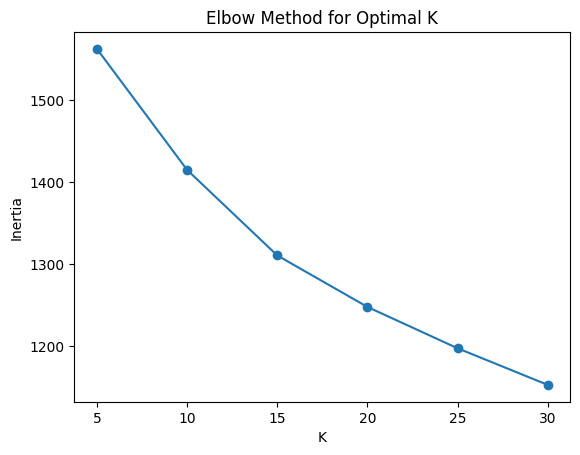

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(5, 31, 5)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(embeddings)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


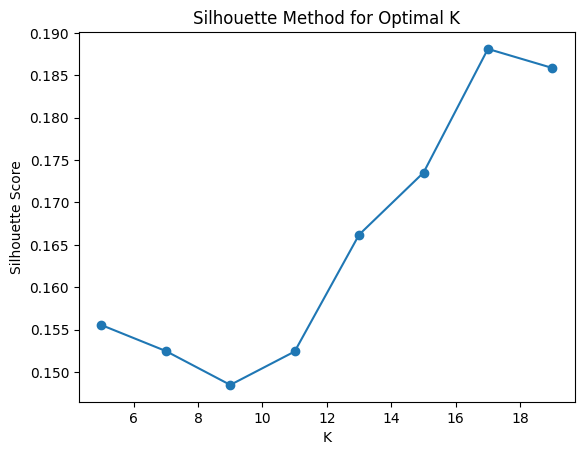

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(5, 21, 2)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels, metric="cosine")
    scores.append(score)

plt.plot(K_range, scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.show()


In [ ]:
k = 15
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=256, n_init=10, random_state=42)
labels = kmeans.fit_predict(embeddings)
df["cluster"] = labels

df["cluster"].value_counts().sort_index()

,count
cluster,
0,163
1,240
2,120
3,203
4,299
5,492
6,366
7,321
8,10


# Step 5: Inspect and interpret clustering results
- Print sample items from each cluster to manually verify semantic coherence
- Use TF-IDF to extract top terms per cluster, helping explain what each group represents
- This step adds transparency and interpretability to unsupervised clustering

# Note:-
We can use here LLM from hugging face and we can directly gave them this cluster to make so logical categories but due to less time I did this manually


In [ ]:
for c in sorted(df["cluster"].unique()):
    sample = df.loc[df["cluster"]==c, TEXT_COL].head(8).tolist()
    print(f"\nCluster {c} (n={len(sample)})")
    for s in sample:
        print("  -", s)



Cluster 0 (n=8)
  - 08 mm deformed straight bar   cr   6m  unit  ton 
  - 14 mm black deformed straight bar g60   12 m   ittifaq  unit  ton 
  - 16 mm black deformed straight bar g60   12m   watani  unit  ton 
  - 09.5 mm deformed straight bar   cr   12m  unit  bundle 
  - 07.7 mm deformed straight bar   cr   6m  unit  bundle 
  - 16 mm black deformed straight bar g60   12m   ittifaq  unit  ton 
  - 12 mm black deformed straight bar g60 12m ittifaq  unit  ton 
  - 07.7 mm deformed straight bar   cr   6m

Cluster 1 (n=8)
  - unknown item
  - unknown item
  - unknown item
  - unknown item
  - unknown item
  - unknown item
  - unknown item
  - unknown item

Cluster 2 (n=8)
  - لفه سلك 61 سم فضي
  - ربل مبروم 4 ملم اسود بال كيلو 
  - لفه سلك 121 سم فضي
  - ربل 3.5 ملم اسود بال كيلو 
  - وصله لسان مسكه ستركتشر ماستر بالجوز master italy conn. block. pair
  - عامود مبروم ستانلس ستيل 304   4 مم   6 م
  - حديد تسليح مجدول سعودي سابك 14 مم   12 م
  - حديد تسليح مجدول سعودي سابك 12 مم   12 م

Cl

In [ ]:
vec = TfidfVectorizer(min_df=5, ngram_range=(1,2))
Xtf = vec.fit_transform(df[TEXT_COL].astype(str))
terms = np.array(vec.get_feature_names_out())

def top_terms_for_cluster(cid, topn=10):
    rows = (df["cluster"] == cid).values
    if rows.sum() == 0:
        return []
    mean_tfidf = Xtf[rows].mean(axis=0).A1
    idx = mean_tfidf.argsort()[::-1][:topn]
    return terms[idx].tolist()

for c in range(k):
    print(f"\nCluster {c} top terms:", top_terms_for_cluster(c, 10))


Cluster 0 top terms: ['deformed', 'deformed straight', 'straight bar', 'straight', 'bar', 'mm', 'black deformed', 'mm black', 'bar g60', 'g60']

Cluster 1 top terms: ['unknown', 'unknown item', 'item', 'cu', 'cu xlpe', 'curved', 'curved type', 'cut', 'cut bend', 'cyl']

Cluster 2 top terms: ['سعودي', 'حديد', '12', 'حديد تسليح', 'تسليح', 'مم', 'مم 12', 'سعودي سابك', 'مجدول', 'سابك']

Cluster 3 top terms: ['توريد', 'concrete', 'مواد', 'for', 'panel', 'polyurethane', 'clip', 'rak', 'الخرسانيه', 'turner']

Cluster 4 top terms: ['ppr', 'aquaterra', '25mm', 'bolt', 'elbow', 'size', '50mm', 'each', 'unit each', 'unit']

Cluster 5 top terms: ['سابك', 'حديد', 'تسليح', 'ملم', '12', 'حديد تسليح', 'سلك', 'اسود', '16', 'اتفاق']

Cluster 6 top terms: ['حديد', 'حديد تسليح', 'تسليح', 'مم', 'متر', 'سابك', '12متر', '12', 'تسليح سابك', 'سماكه']

Cluster 7 top terms: ['sheet', 'mm', 'مم', 'hr', 'سماكه', 'hr sheet', '6000', 'مقاس', '1220', 'hdg']

Cluster 8 top terms: ['to', 'port', 'riyadh', 'only', 'the

In [ ]:
centers = kmeans.cluster_centers_
dists = cosine_distances(embeddings, centers)
df["rep_score"] = dists[np.arange(len(df)), df["cluster"]]

representatives = df.sort_values(["cluster", "rep_score"]).groupby("cluster").head(1)
representatives[["cluster", TEXT_COL]]

,cluster,Clean Item Name
882,0,16 mm black deformed straight bar g60 12 m sabic
0,1,unknown item
534,2,حديد تسليح مجدول سعودي سابك 14 مم 12 م
2858,3,علب فيوز معدنيه مزدوجه مع 2 قاطع 10 امبير
835,4,bend 45 pvc aplaco 75mm
1091,5,صاج اسود 2 6 15 مم
2852,6,حديد مجدول 14 مم ط 12 م الراجحي
1809,7,hr sheet 5.80 x 1220 x 2440 mm
2863,8,freight bangkok to dammam
300,9,مسكه سحاب جانبي مخفي اسود giesse r. h. e. 145 ...


# Step 6: Assign human-readable labels to clusters
- Based on manual inspection of sample items and top TF-IDF terms
- Creates a mapping from cluster ID to domain-specific category
- Adds a new column 'cluster_category' for easier interpretation and downstream use


In [ ]:
cluster_map = {
    0: "Steel & Rebar",
    1: "Unknown",
    2: "Electrical",
    3: "Sheets & Metals",
    4: "HVAC",
    5: "Fasteners & Hardware",
    6: "Cement & Gypsum",
    7: "Lighting",
    8: "Plumbing & Sanitary",
    9: "Valves & Controls",
    10: "Paints & Coatings",
    11: "Wood & Panels",
    12: "Oils & Lubricants",
    13: "Adhesives & Sealants",
    14: "Tools & Equipment",
}

df["cluster_category"] = df["cluster"].map(cluster_map).fillna("Unlabeled")

In [ ]:
df.head()

,Item ID,Item Name,Quantity,Total Bcy,Purchase Order ID,Currency Code,Account ID,Total Spend in SAR,Unit Price,Clean Item Name,cluster,rep_score,cluster_category
0,3263831000000089042,Unknown Item,75.21,227510.25,3263831000000089040,SAR,3263831000000034003,227510.25,3025.0,unknown item,1,0.000000e+00,Unknown
1,3263831000000089046,Unknown Item,15.00,47250.00,3263831000000089040,SAR,3263831000000034003,47250.00,3150.0,unknown item,1,0.000000e+00,Unknown
2,3263831000000089044,Unknown Item,50.00,160000.00,3263831000000089040,SAR,3263831000000034003,160000.00,3200.0,unknown item,1,0.000000e+00,Unknown
3,3263831000000092044,Unknown Item,12.00,38280.00,3263831000000092040,SAR,3263831000000034003,38280.00,3190.0,unknown item,1,1.192093e-07,Unknown
4,3263831000000092052,Unknown Item,2.00,5900.00,3263831000000092040,SAR,3263831000000034003,5900.00,2950.0,unknown item,1,1.192093e-07,Unknown


# Step 7: Analyze spend distribution across cluster categories
- Group items by assigned category and sum total spend
- Calculate each category's proportion of overall spend
- Helps identify high-impact clusters for prioritization or deeper analysis


In [ ]:
spend_by_cat = df.groupby("cluster_category")["Total Spend in SAR"].sum().sort_values(ascending=False)

total_spend = spend_by_cat.sum()
spend_summary = spend_by_cat.reset_index()
spend_summary["proportion_%"] = (spend_summary["Total Spend in SAR"] / total_spend * 100).round(2)

print(spend_summary)

        cluster_category  Total Spend in SAR  proportion_%
0        Cement & Gypsum        2.863143e+07         18.28
1   Fasteners & Hardware        2.195259e+07         14.02
2                Unknown        1.512149e+07          9.66
3        Sheets & Metals        1.385343e+07          8.85
4          Steel & Rebar        1.338789e+07          8.55
5             Electrical        9.680591e+06          6.18
6      Valves & Controls        9.551144e+06          6.10
7               Lighting        8.899148e+06          5.68
8   Adhesives & Sealants        8.290344e+06          5.29
9      Tools & Equipment        8.003275e+06          5.11
10                  HVAC        7.998381e+06          5.11
11         Wood & Panels        5.564686e+06          3.55
12     Oils & Lubricants        3.410465e+06          2.18
13     Paints & Coatings        2.112562e+06          1.35
14   Plumbing & Sanitary        1.459371e+05          0.09


# Step 8: Visualize spend distribution across categories
- Create a bar chart showing total spend per cluster category
- Helps quickly identify which categories dominate procurement costs
- Useful for stakeholders to prioritize sourcing, budgeting, or optimization efforts


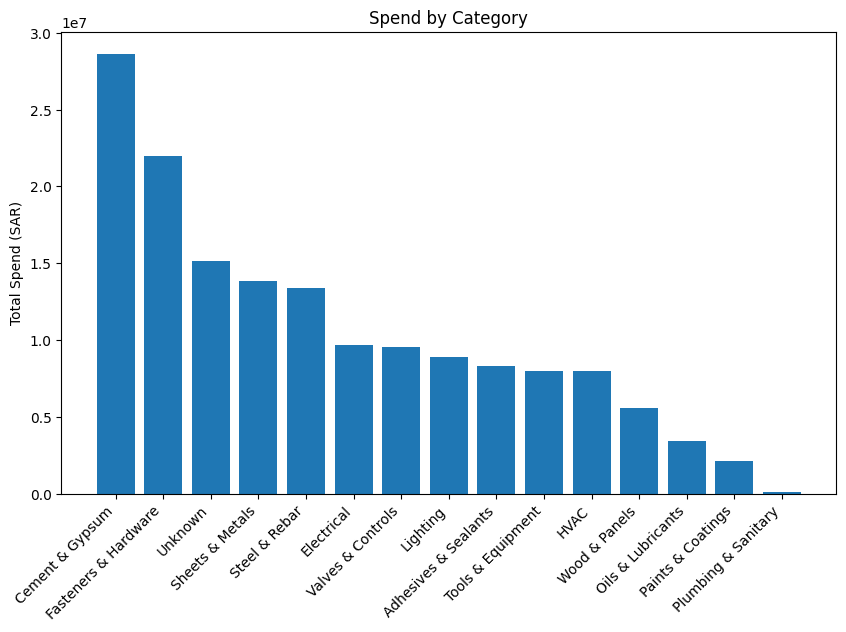

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(spend_summary["cluster_category"], spend_summary["Total Spend in SAR"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Spend (SAR)")
plt.title("Spend by Category")
plt.show()


# Step 9: Visualize proportional spend across categories
- Create a pie chart to show each category’s share of total spend
- Highlights dominant clusters in terms of budget allocation
- Useful for quick, high-level insights and stakeholder presentations


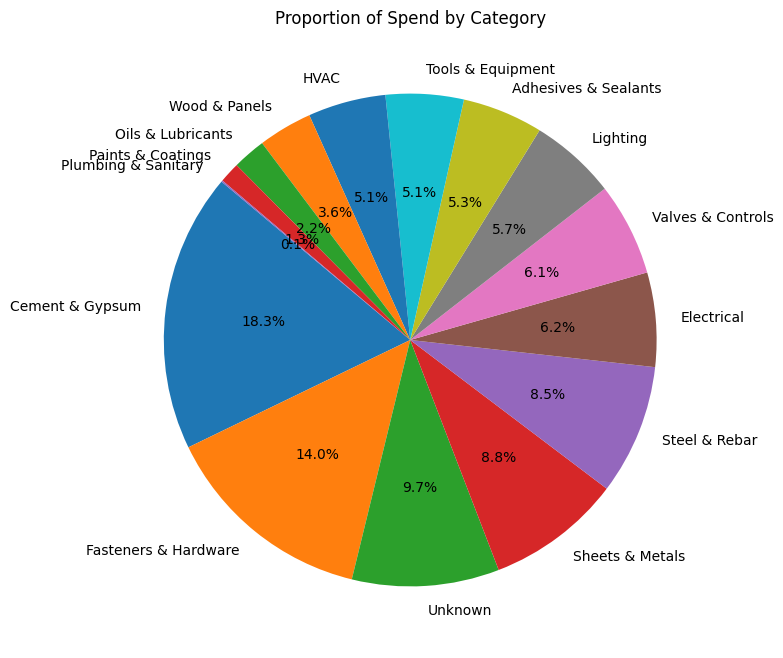

In [19]:
plt.figure(figsize=(8,8))
plt.pie(spend_summary["Total Spend in SAR"],
        labels=spend_summary["cluster_category"],
        autopct="%.1f%%", startangle=140)
plt.title("Proportion of Spend by Category")
plt.show()


# Step 10: Analyze and visualize spend distribution by Account ID
- Aggregate total spend per account to identify top spenders
- Pivot spend data by account and category to understand purchasing patterns
- Visualize top accounts using a stacked bar chart to show category-wise spend
- Helps uncover which accounts drive procurement and what they’re buying


In [20]:
spend_by_account = df.groupby("Account ID")["Total Spend in SAR"].sum().sort_values(ascending=False)
spend_by_account = spend_by_account.reset_index()
print(spend_by_account.head())


            Account ID  Total Spend in SAR
0  3263831000000034003        1.566034e+08
1  3263831000000000409        7.000000e+00


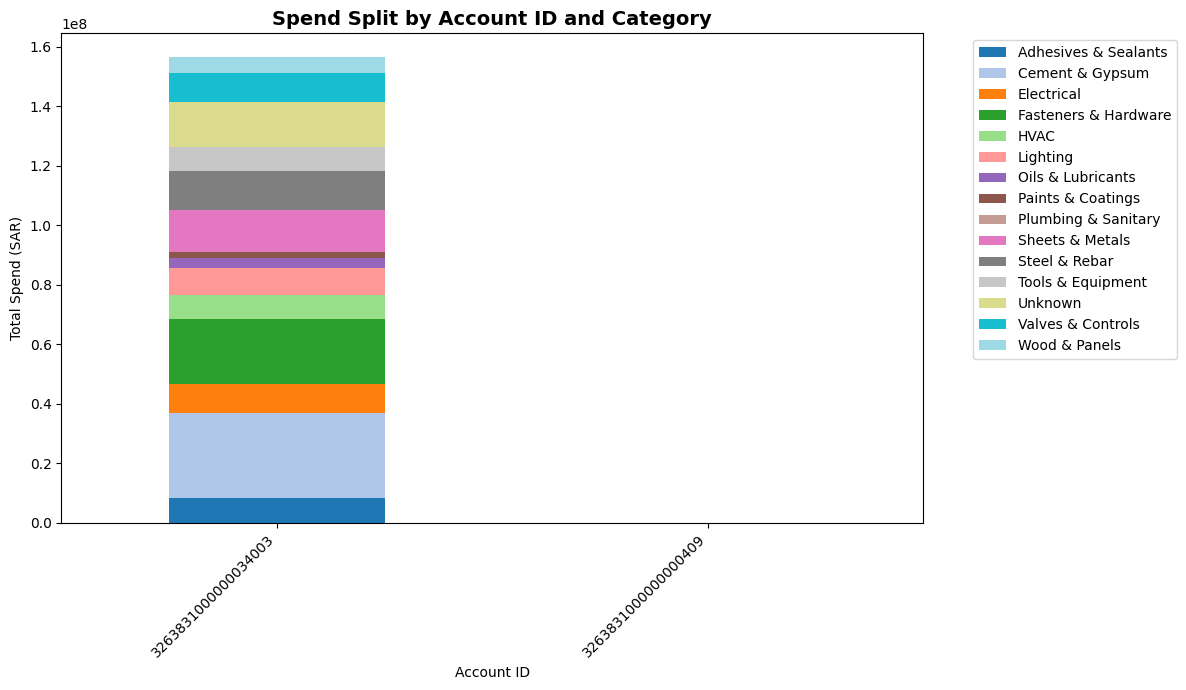

In [21]:
spend_account_cat = df.groupby(["Account ID","cluster_category"])["Total Spend in SAR"].sum().reset_index()
pivot = spend_account_cat.pivot(index="Account ID", columns="cluster_category", values="Total Spend in SAR").fillna(0)

# Sort by total spend and take top accounts
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(10).index]

pivot.plot(kind="bar", stacked=True, figsize=(12,7), colormap="tab20")
plt.ylabel("Total Spend (SAR)")
plt.title("Spend Split by Account ID and Category", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


# There are only two accounts involved, with the majority of the expenditure attributed to a single account.